## Sandbox

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import

import numpy as np
import glob
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
import calibrate
import cv2
import binary
import transform 

from lanes import histogram

%matplotlib inline

In [3]:
# Calibrate camera
calib_paths = glob.glob('./camera_cal/*.jpg')
obj_pts, img_pts = calibrate.collect_obj_img_pts(calib_paths)

FPS: 25.0
Duration: 50.4
Frames: 1260.0


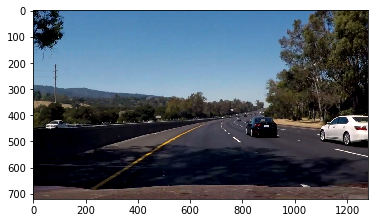

In [4]:
# Get test image
# test_image = cv2.imread('./test_images/straight_lines2.jpg')
# test_image = cv2.imread('./test_images/test6.jpg')

# rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
# plt.imshow(rgb, cmap='gray')

clip = VideoFileClip('./project_video.mp4')
print('FPS: {}'.format(clip.fps))
print('Duration: {}'.format(clip.duration))
print('Frames: {}'.format(clip.fps * clip.duration))

# test_image = clip.get_frame(0)
test_image = clip.get_frame(41.88)
# test_image = clip.get_frame(24.52)
# test_image = clip.get_frame(.76)
# test_image = clip.get_frame(6.12)
# test_image = clip.get_frame(30.24)
# test_image = clip.get_frame(30.48)
plt.imshow(test_image, cmap='gray')

(1280, 720)
MTX: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Dist: [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


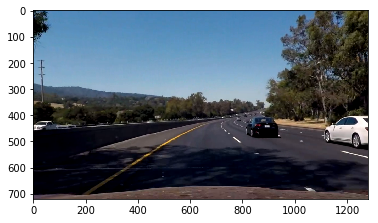

In [5]:
# Undistort image
img_size = (test_image.shape[1], test_image.shape[0])
print(img_size)
_, mtx, dist, _, _ = calibrate.calibrate_camera(obj_pts, img_pts, img_size)

print('MTX: {}'.format(mtx))
print('Dist: {}'.format(dist))
undistort = calibrate.undistort(test_image, mtx, dist)
undistort_rgb = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)

plt.imshow(undistort, cmap='gray')
# plt.imshow(undistort_rgb, cmap='gray')

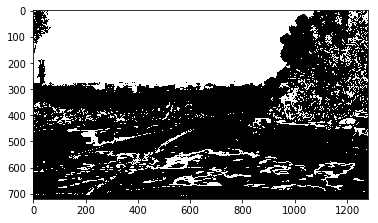

In [6]:
# Color space

hls = binary.hls_select(undistort, ch_filter=2, thresh=(90, 190))
plt.imshow(hls, cmap='gray')

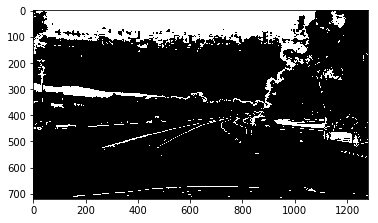

In [7]:
# RGB

rgb = binary.rgb_select(undistort, thresh=(95, 190))
plt.imshow(rgb, cmap='gray')

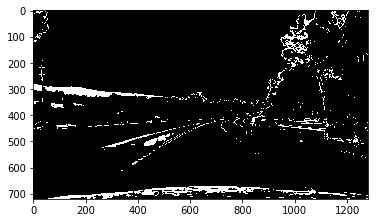

In [8]:
# HSV

hsv = binary.hsv_select(undistort, thresh=(100, 150))
plt.imshow(hsv, cmap='gray')

In [10]:
# # Sobel (abs)

# sobel_x = sobel.abs_sobel_thresh(undistort, orient='x', thresh=(20, 255))
# sobel_y = sobel.abs_sobel_thresh(undistort, orient='y', thresh=(20, 255))

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(sobel_x, cmap='gray')
# ax1.set_title('Sobel X', fontsize=50)

# ax2.imshow(sobel_y, cmap='gray')
# ax2.set_title('Sobel Y', fontsize=50)

# plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

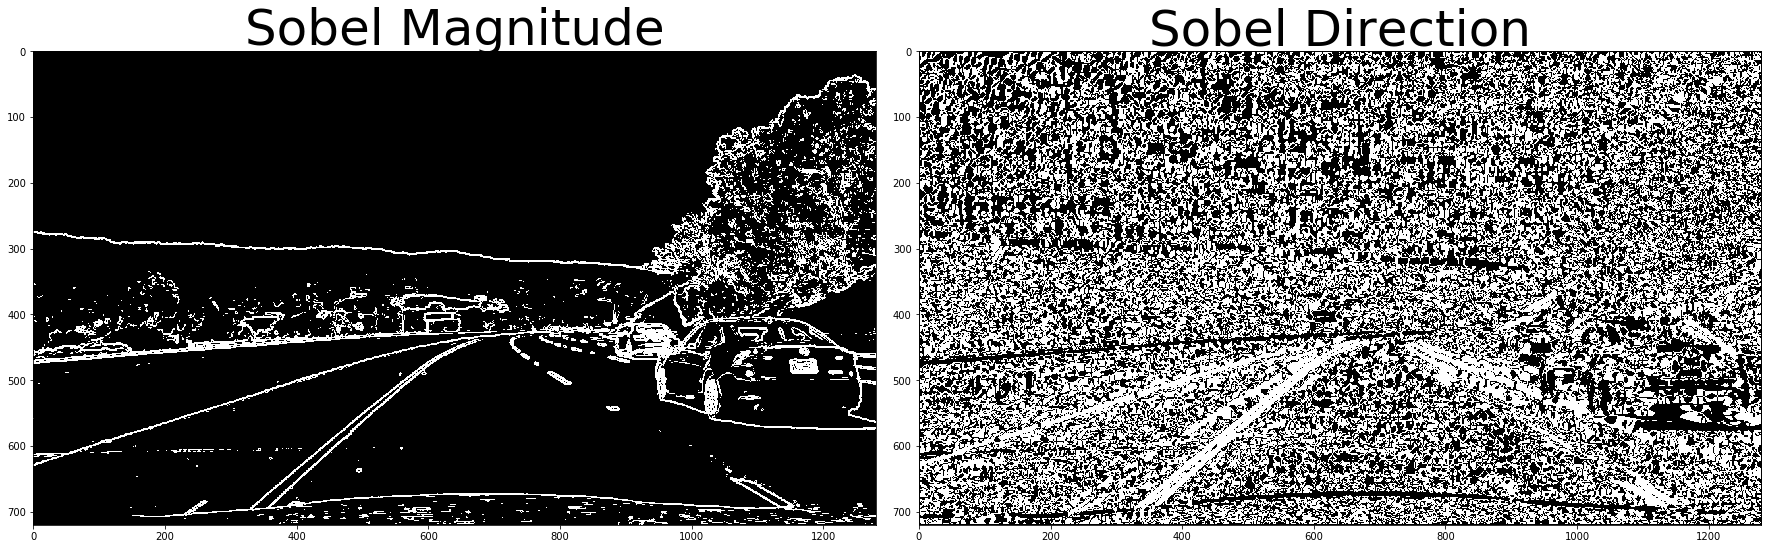

In [11]:
# Sobel dir

mag = binary.mag_thresh(undistort, thresh=(20, 255))
# direct = sobel.dir_thresh(undistort, thresh=(np.pi/4, np.pi/2))
# direct = sobel.dir_thresh(undistort, thresh=(np.pi/10, np.pi/3))
direct = binary.dir_thresh(undistort, thresh=(0.6, 1.4), kernel=15)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(mag, cmap='gray')
ax1.set_title('Sobel Magnitude', fontsize=50)

ax2.imshow(direct, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=50)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

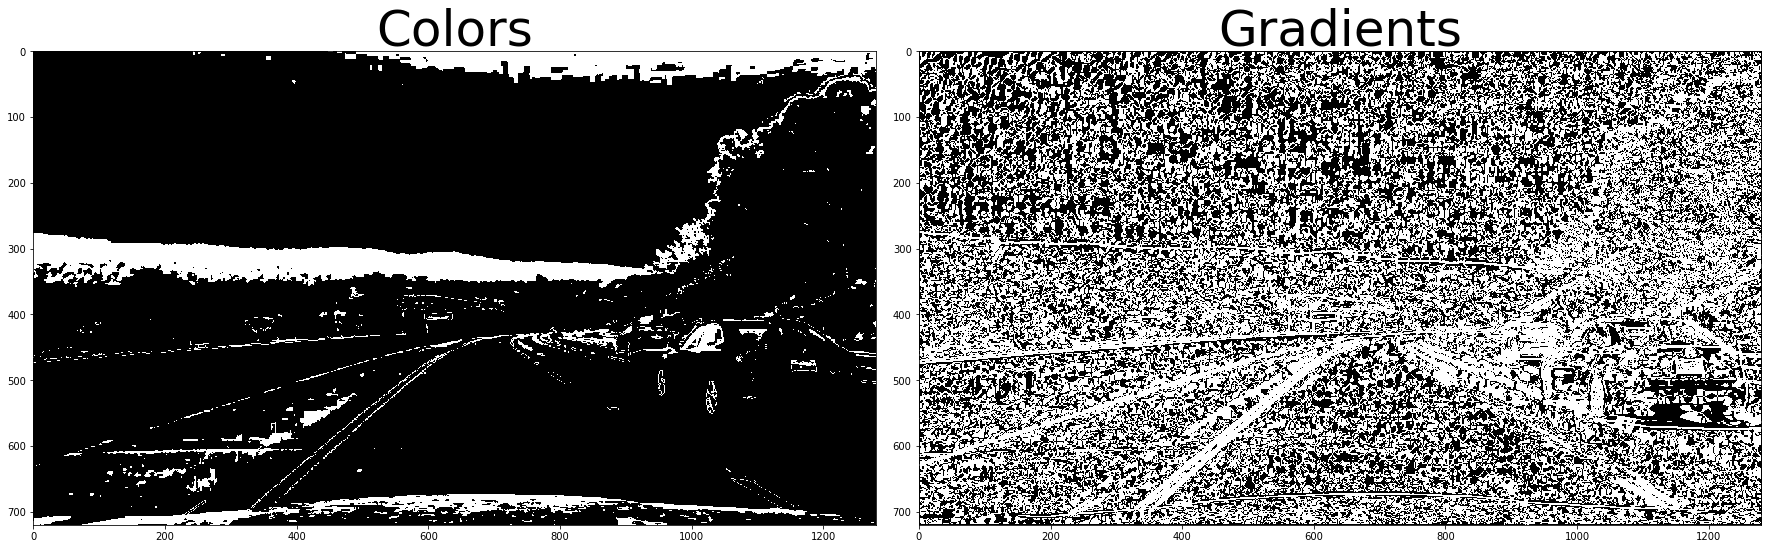

In [12]:
colors = np.zeros_like(rgb)
gradients = np.zeros_like(rgb)

# combined = np.zeros_like(hls)
# combined_2 = np.zeros_like(hls)

# combined[((hls == 1) & (direct == 1)) | 
#          ((direct == 1) & (mag == 1)) | 
#          ((hls == 1) & (mag == 1))] = 1

colors[((hls == 1) & (rgb == 1)) |
       ((hls == 1) & (hsv == 1)) |
       ((rgb == 1) & (hsv == 1))] = 1

gradients[(mag == 1) | (direct == 1)] = 1

# combined_2[(colors == 1) & (mag == 1) & (direct == 1)] = 1

# combined[((colors == 1) & (direct == 1)) | 
#          ((direct == 1) & (mag == 1)) | 
#          ((colors == 1) & (mag == 1))] = 1

# plt.imshow(combined, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(colors, cmap='gray')
ax1.set_title('Colors', fontsize=50)

ax2.imshow(gradients, cmap='gray')
ax2.set_title('Gradients', fontsize=50)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

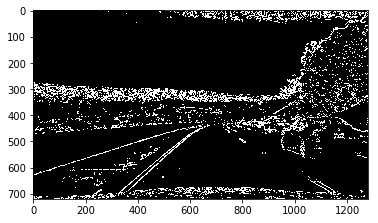

In [13]:
combined = np.zeros_like(rgb)
# combined[(colors == 1) & (gradients == 1)] = 1
combined[((colors == 1) & (direct == 1)) | 
         ((direct == 1) & (mag == 1)) | 
         ((colors == 1) & (mag == 1))] = 1
plt.imshow(combined, cmap='gray')

(720, 1280, 3)


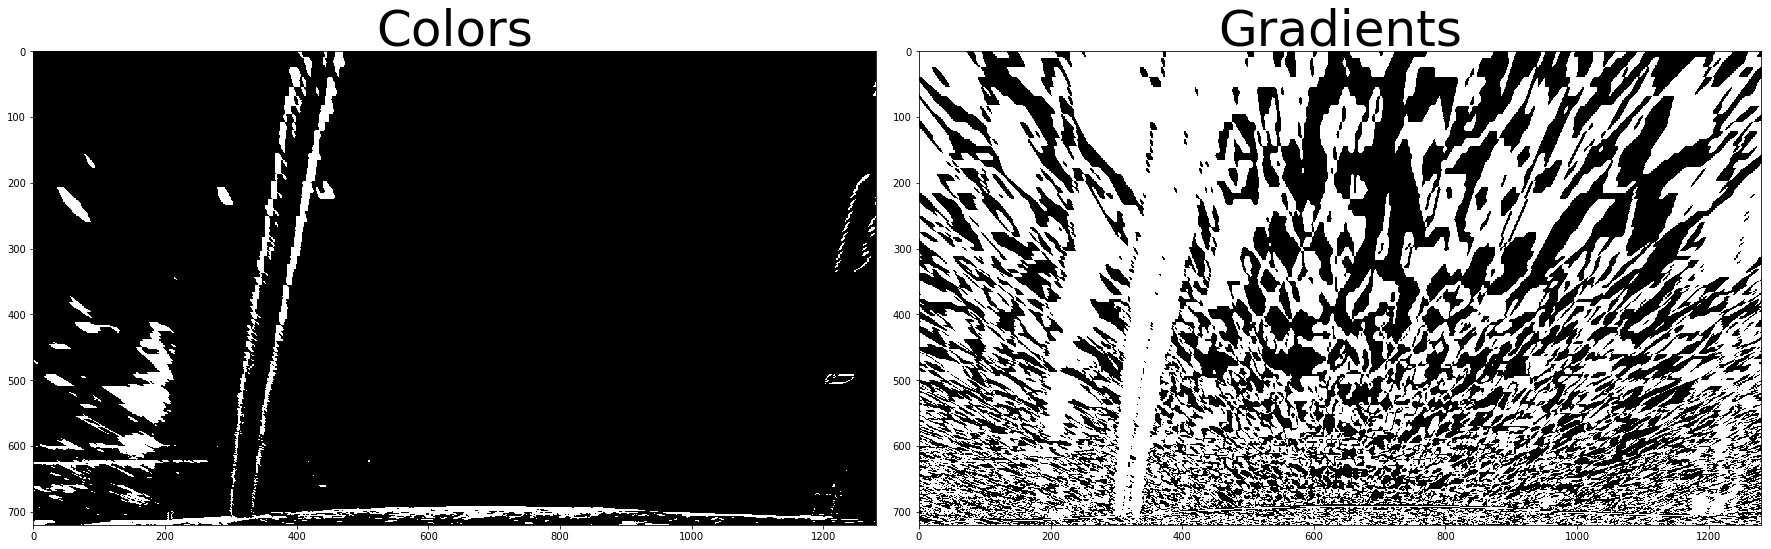

In [14]:
print(undistort.shape)

# src = transform.SOURCE
# dst = transform.DEST

src = np.float32([
    (507, 500),
    (792, 500),
    (150, 720),
    (1200, 720)
])
dst = np.float32([
    (150, 300),
    (1200, 300),
    (150, 720),
    (1200, 720)
])

c_warped = transform.transform(colors, src, dst)
g_warped = transform.transform(gradients, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(c_warped, cmap='gray')
ax1.set_title('Colors', fontsize=50)

ax2.imshow(g_warped, cmap='gray')
ax2.set_title('Gradients', fontsize=50)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

# plt.imshow(warped, cmap='gray')

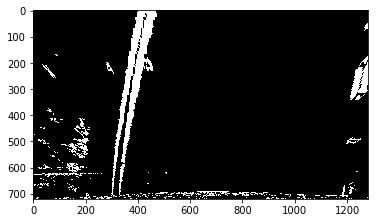

In [15]:
warped = transform.transform(combined, src, dst)
plt.imshow(warped, cmap='gray')

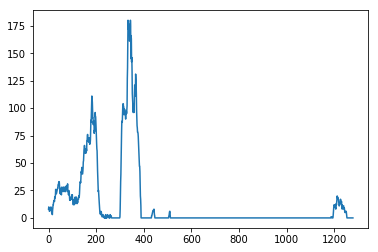

In [16]:
# Find lines with histogram
hist = histogram.histogram(warped, hood_height=50)
plt.plot(hist)

In [17]:
# Perform search
sw = histogram.SlidingWindow(warped)
sw.search()

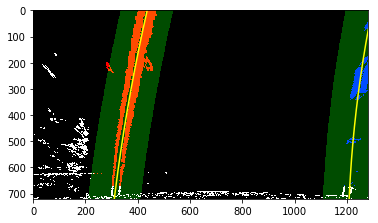

In [18]:
# Visualize search
sw.visualize()

In [19]:
sw.curvature_ft()

(1147.5352277800778, 778.05172117977793)

In [22]:
sw.center_offset()

2.8668159590688593

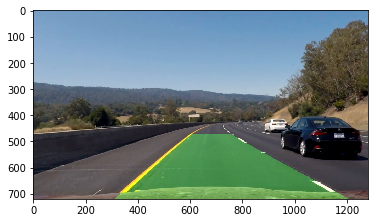

In [28]:
result = transform.unwarp_lane(
    warped, 
#     orig_img=cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB),
    orig_img=undistort,
    src=src, dst=dst,
    plot_y=sw.plot_y,
    left_x=sw.left_x, right_x=sw.right_x    
)
plt.imshow(result, cmap='gray')

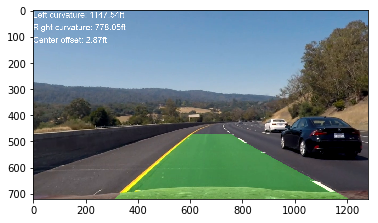

In [43]:
from PIL import Image, ImageDraw, ImageFont

out_img = Image.fromarray(result)

font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 32)

draw = ImageDraw.Draw(out_img)
left_curve, right_curve = sw.curvature_ft()

draw.text(
    (0, 0), 
    'Left curvature: {}ft'.format(round(left_curve, 2)),
    font=font
)
draw.text(
    (0, 48), 
    'Right curvature: {}ft'.format(round(right_curve, 2)),
    font=font
)
draw.text(
    (0, 96),
    'Center offset: {}ft'.format(round(sw.center_offset(), 2)),
    font=font
)

plt.imshow(out_img, cmap='gray')

------

## Appendix

In [ ]:
import run

In [ ]:
undistort = calibrate.undistort(test_image, mtx, dist)
plt.imshow(undistort, cmap='gray')

In [ ]:
# binary = run.apply_filters(undistort)
# plt.imshow(binary)
hls = hls_select(undistort, thresh=(90, 255))
plt.imshow(hls, cmap='gray')

In [ ]:
mag = sobel.mag_thresh(undistort, thresh=(20, 255))
plt.imshow(mag, cmap='gray')

In [ ]:
direction = sobel.dir_thresh(undistort, thresh=(0.6, 1.4), kernel=15)
plt.imshow(direction, cmap='gray')

In [ ]:
combined = np.zeros_like(hls)
plt.imshow(combined, cmap='gray')

In [ ]:
combined[((hls == 1) & (direction == 1)) |
         ((direction == 1) & (mag == 1)) |
         ((hls == 1) & (mag == 1))] = 1
plt.imshow(combined, cmap='gray')

In [ ]:
p = run.ImageProcessor(mtx, dist, src, dst)

In [ ]:
res = p.process_image(test_image)
plt.imshow(res)

In [ ]:
rgb = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)
plt.imshow(undistort, cmap='gray')

In [ ]:
processed_clip = VideoFileClip('./processed_project_video.mp4')
img = processed_clip.get_frame(41.88)
plt.imshow(img)